# American Sign Language Gesture Recognition Using CNN's with Images 
  
Author:       Mansur Amin <br>
Team:         ASL Dynamics <br>
Team Members: Matt Wnuk, Juan Castillo <br>
Class:        ECE 285 Spring 2018 : Machine Learning for Computer Vision <br>

- Build a convolutional neural network with TensorFlow for for gesture recogination using the MNIST ASL Dataset avaiable on Kaggel.

- This project uses TensorFlow layers API for a raw TensorFlow implementation with variables. <br>
Reference: Aymeric Damien's project to recognize digits in images from the MNIST digits dataset <br>
Reference source: https://github.com/aymericdamien/TensorFlow-Examples/ <br>

## CNN Overview

Convolutional Neural network 

![CNN](https://cdn-images-1.medium.com/max/1400/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)

## MNIST Dataset Overview

This example is using MNIST ASL Hand Gestures. The dataset contains 27,456 examples for training and 7,173 examples for testing. The images have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST](https://www.kaggle.com/databundle/preview/image-dataset/3258/5337/5337/15172)

More info: https://www.kaggle.com/datamunge/sign-language-mnist/data

In [1]:
####################################################################
# Libraries 
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#####################################################################
# def read_data(path) :
# Reads data specidfed by path and stores into numpy array, Splits data nad lbl
# path = location of where data is stored
#####################################################################
def read_data(path) :
    num_lines = sum(1 for line in open(path)) # get number of lines in file
    myfile = open(path,'r')
    j = 0
    read_lines = np.zeros((num_lines,785))    # expects a 25x25 pixel row vector
    for line in myfile :
        if(j >= 1) :
            read_lines[j,:] = np.asarray(line.split(','))
        j = j+1
    myfile.close()
    
    print('Initlal', path[63:68], 'Shape:', read_lines.shape)
    read_lines = np.delete(read_lines,0,0) # remove pixel labels row from frost row
    labels = read_lines[:,0]
    read_lines = np.delete(read_lines,0,1) # remove labels from first collumn
    print('Augmented', path[63:68], 'Shape:', read_lines.shape)
    return read_lines,labels.astype(np.int16) # .reshape(len(labels),1)

#####################################################################
# def vis_data(dat_vec,dat_lbl) :
# Visualize data.
# dat_vec = vector representing data
# dat_lbl = label representing data
#####################################################################
def vis_data(dat_vec,dat_lbl) :
    lbl_map = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    dat_mat = dat_vec.reshape(28,28)
    plt.title('Image Label = ' + str(dat_lbl) + ' = ' + lbl_map[dat_lbl])
    plt.imshow(dat_mat, cmap='gray')
    
#####################################################################
# def normalize_MNIST_images(x) :
# Normalize data in range of -1 to 1
# x = vector representing data
#####################################################################
def normalize_MNIST_images(x,max_x, diff) : 
    x = x.astype(np.float64)
    x = max_x*(x-np.min(x))/(np.max(x)-np.min(x))-diff
    print("Normalize_MNIST_images", x.shape)
    return x

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## Read ASL MNIST data
####################################################################
# # Windows Path
# train_path = 'C:\\Users\\maamin\\Desktop\\ECE_285_ML_DL\\data\\sign_mnist_train.csv'
# test_path = 'C:\\Users\\maamin\\Desktop\\ECE_285_ML_DL\\data\\sign_mnist_test.csv'
####################################################################
# # Mac path
# train_path = '/Users/mansuramin/Desktop/ECE_285_ML/data/sign_mnist_train.csv'
# test_path = '/Users/mansuramin/Desktop/ECE_285_ML/data/sign_mnist_test.csv'
####################################################################
# ieng6 Server Path
train_path = '/datasets/ee285s-public/KaggleASL/Kaggle_ASL_Images/sign_mnist_train.csv'
test_path = '/datasets/ee285s-public/KaggleASL/Kaggle_ASL_Images/sign_mnist_test.csv'
####################################################################
# Load data from path
xtrain,ltrain = read_data(train_path)
xtest,ltest = read_data(test_path)
####################################################################
# Normalize between 0 and 1
xtrain = normalize_MNIST_images(xtrain,1,0)
xtest = normalize_MNIST_images(xtest,1,0)
####################################################################
# Change Types to match nn types
xtrain = xtrain.astype(np.float32)
ltrain = ltrain.astype(np.uint8)
xtest = xtest.astype(np.float32)
ltest = ltest.astype(np.uint8)

Initlal train Shape: (27456, 785)
Augmented train Shape: (27455, 784)
Initlal test. Shape: (7173, 785)
Augmented test. Shape: (7172, 784)
Normalize_MNIST_images (27455, 784)
Normalize_MNIST_images (7172, 784)


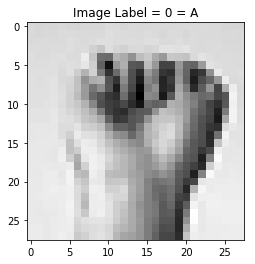

In [3]:
####################################################################
# Visualize a train image A
indx = 46
vis_data(xtrain[indx,:],ltrain[indx])

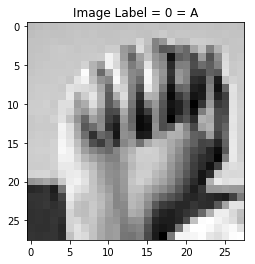

In [4]:
####################################################################
# Visualize a test image A
indx = 3
vis_data(xtest[indx,:],ltest[indx])

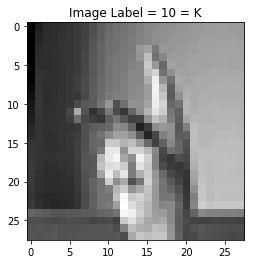

In [5]:
####################################################################
# Visualize a train image K
indx = 11
vis_data(xtrain[indx,:],ltrain[indx])

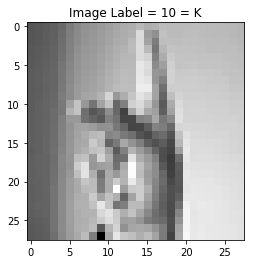

In [6]:
####################################################################
# Visualize a test image K
indx = 2
vis_data(xtest[indx,:],ltest[indx])

In [7]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 25 # MNIST total classes (0-24 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [8]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 3
        conv1 = tf.layers.max_pooling2d(conv1, 3, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 3
        conv2 = tf.layers.max_pooling2d(conv2, 3, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)
        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc2 = tf.contrib.layers.flatten(fc1)
        # Fully connected layer (in tf contrib folder for now)
        fc2 = tf.layers.dense(fc2, 512)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc2 = tf.layers.dropout(fc2, rate=dropout, training=is_training)
        
        # Flatten the data to a 1-D vector for the fully connected layer
        fc3 = tf.contrib.layers.flatten(fc2)
        # Fully connected layer (in tf contrib folder for now)
        fc3 = tf.layers.dense(fc3, 256)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc3 = tf.layers.dropout(fc3, rate=dropout, training=is_training)
        
        
        # Output layer, class prediction
        out = tf.layers.dense(fc3, n_classes)

    return out

In [9]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [10]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6d5ae5ae10>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmppIfpyk', '_save_summary_steps': 100}


In [11]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': xtrain}, y=ltrain,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmppIfpyk/model.ckpt.
INFO:tensorflow:loss = 3.236732, step = 1
INFO:tensorflow:global_step/sec: 204.605
INFO:tensorflow:loss = 0.5162809, step = 101 (0.491 sec)
INFO:tensorflow:global_step/sec: 236.851
INFO:tensorflow:loss = 0.1459913, step = 201 (0.422 sec)
INFO:tensorflow:global_step/sec: 237.255
INFO:tensorflow:loss = 0.12061401, step = 301 (0.422 sec)
INFO:tensorflow:global_step/sec: 238.351
INFO:tensorflow:loss = 0.050065134, step = 401 (0.419 sec)
INFO:tensorflow:global_step/sec: 232.618
INFO:tensorflow:loss = 0.0056178337, step = 501 (0.430 sec)
INFO:tensorflow:global_step/sec: 234.544
INFO:tensorflow:loss = 0.010855708, step = 601 (0.426 sec)
INFO:tensorflow:global_step/sec: 236.136
INFO:tensorflow:loss = 0.0019085205, step = 701 (0.423 sec)
INFO:tensorflow:global_step/sec: 235.959
INFO:tensorflow:loss = 0.0018521114, step = 801 (0.424 sec)
INFO:tensorflow:global_step/sec: 235.489
IN

In [12]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': xtest}, y=ltest,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2018-06-01-21:13:42
INFO:tensorflow:Restoring parameters from /tmp/tmppIfpyk/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2018-06-01-21:13:42
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9470162, global_step = 2000, loss = 0.3436322


{'accuracy': 0.9470162, 'global_step': 2000, 'loss': 0.3436322}

In [13]:
# Predict single images
n_images = 7172
# Get images from test set
test_images = xtest[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))
lbl_map = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']


INFO:tensorflow:Restoring parameters from /tmp/tmppIfpyk/model.ckpt-2000


In [14]:
# Count the number of correct predictions
counter = 0
for i in range (n_images) :
    if(preds[i] == ltest[i]):
        counter = counter + 1
print("Number of accurate predictions: ",counter)  
print("Total Number of images: ",n_images) 

Number of accurate predictions:  6792
Total Number of images:  7172


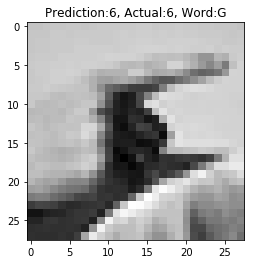

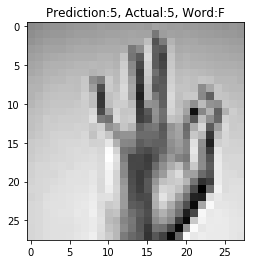

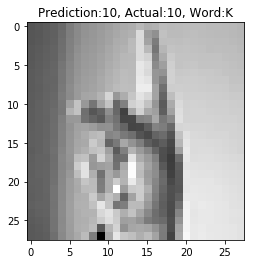

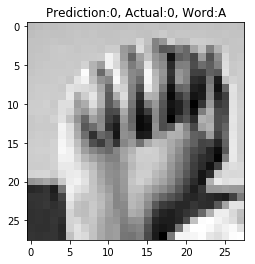

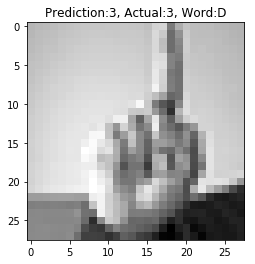

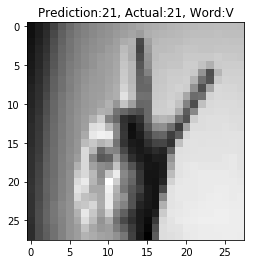

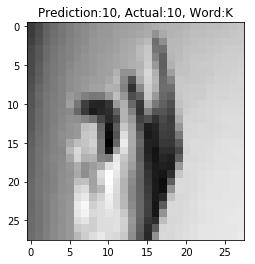

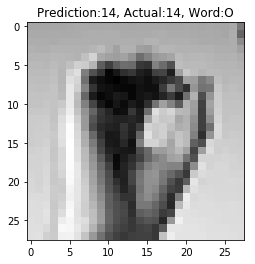

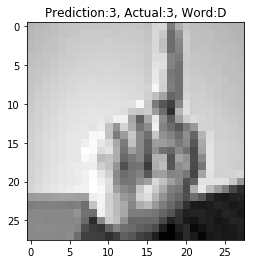

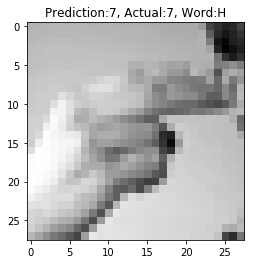

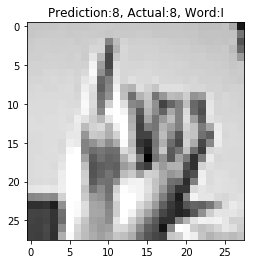

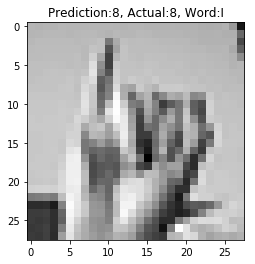

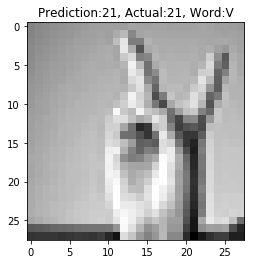

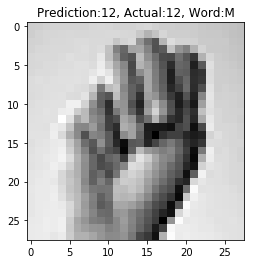

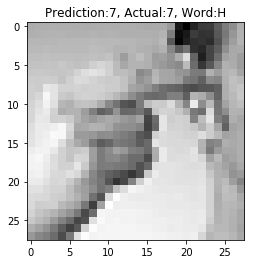

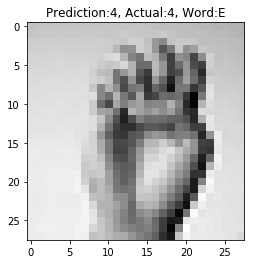

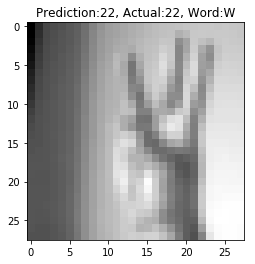

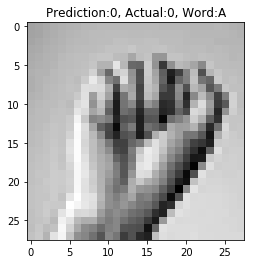

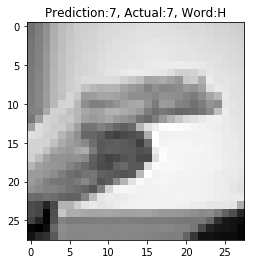

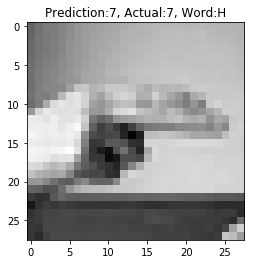

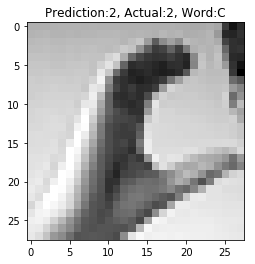

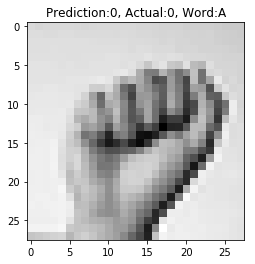

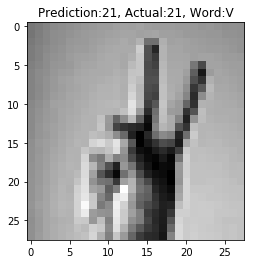

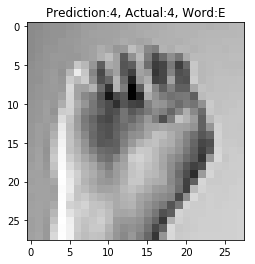

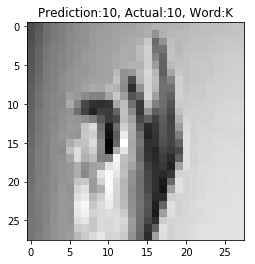

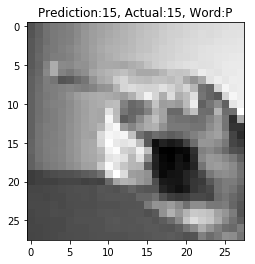

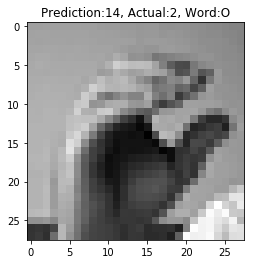

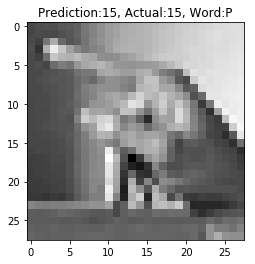

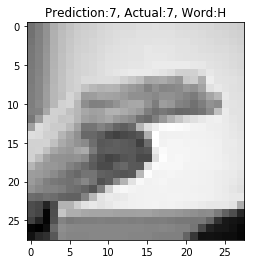

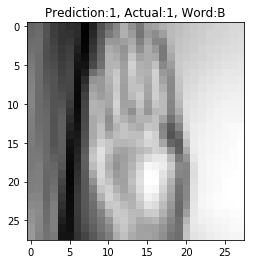

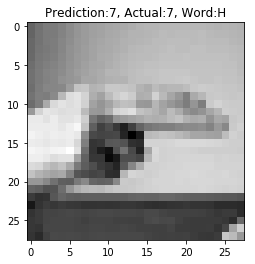

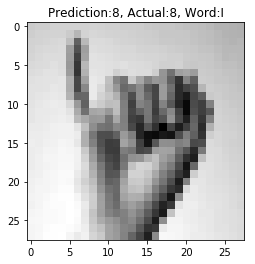

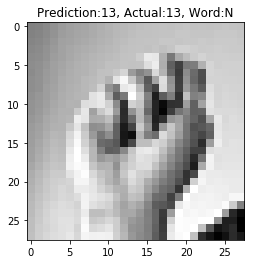

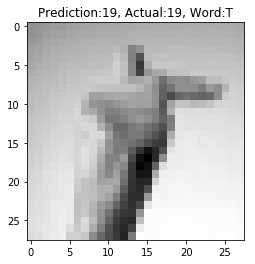

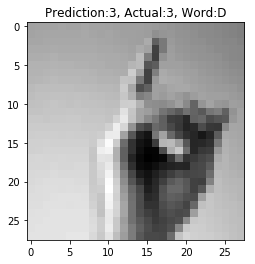

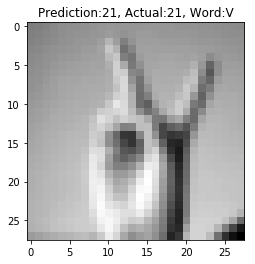

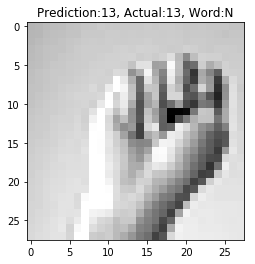

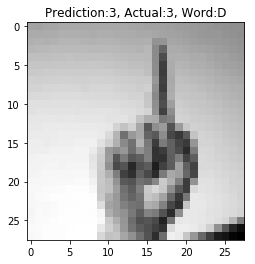

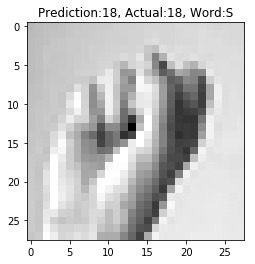

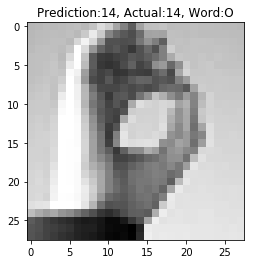

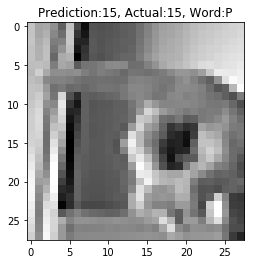

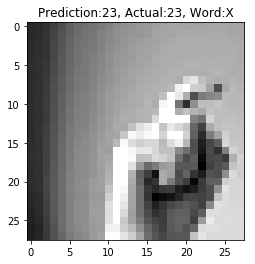

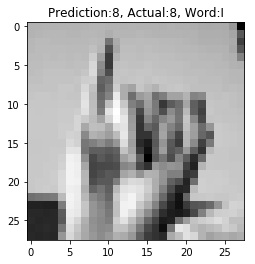

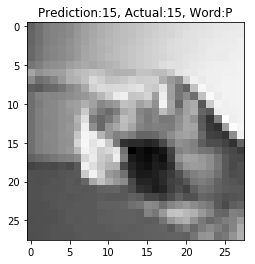

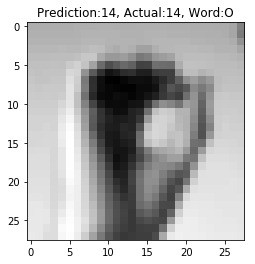

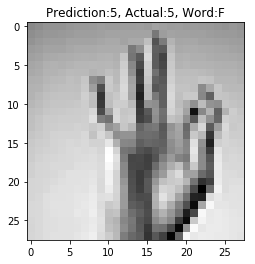

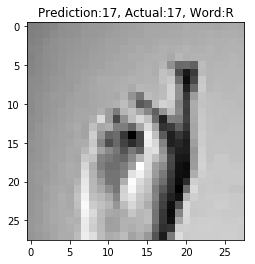

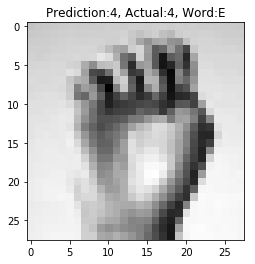

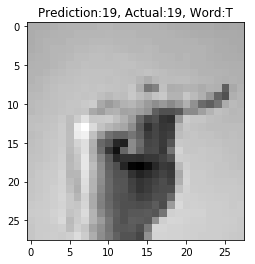

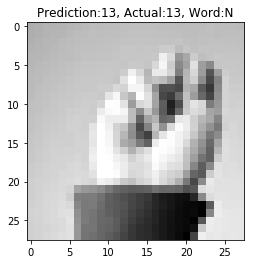

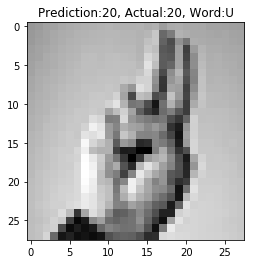

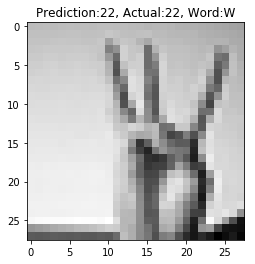

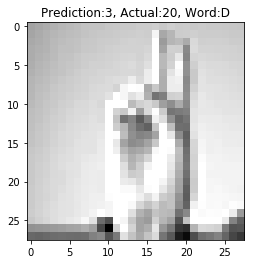

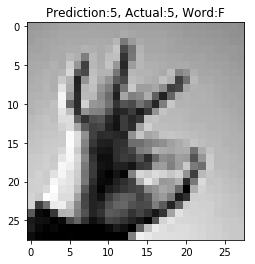

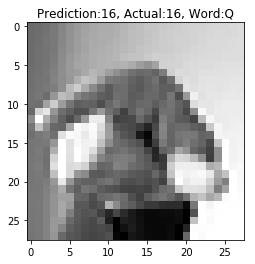

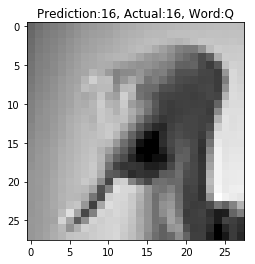

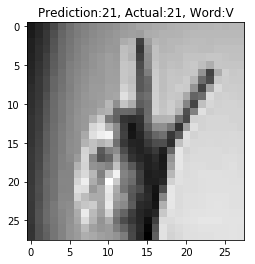

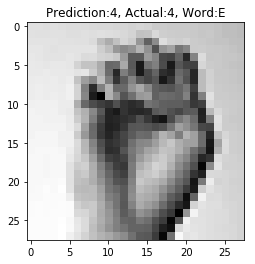

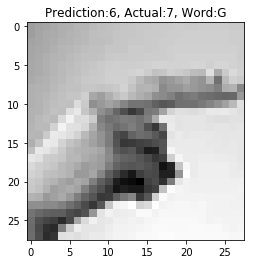

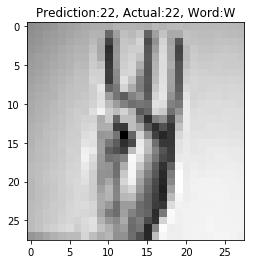

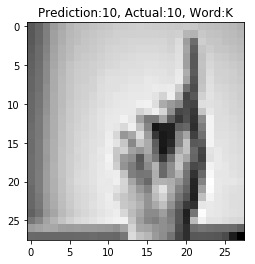

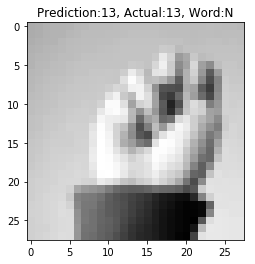

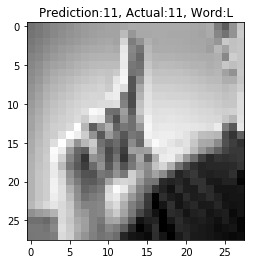

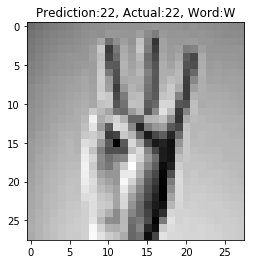

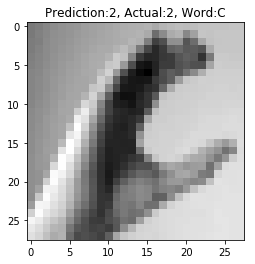

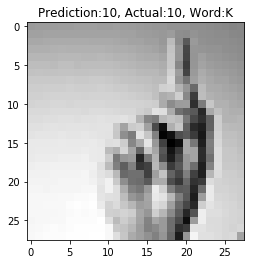

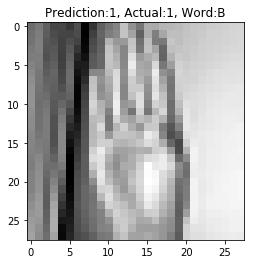

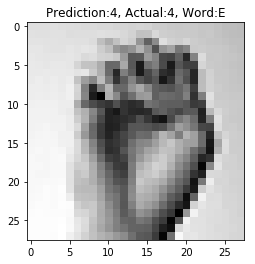

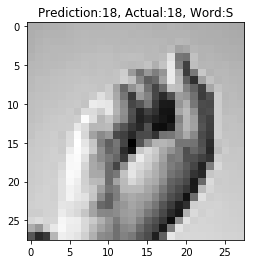

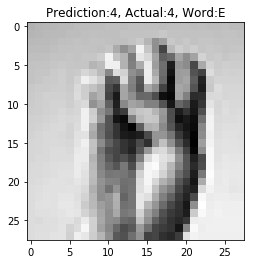

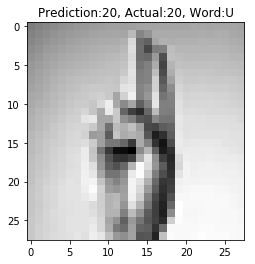

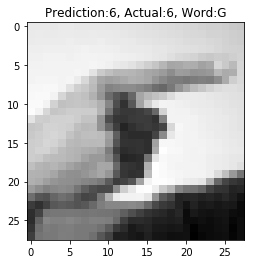

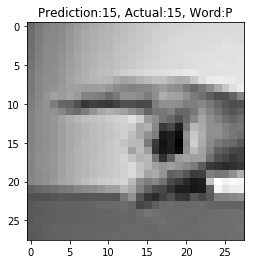

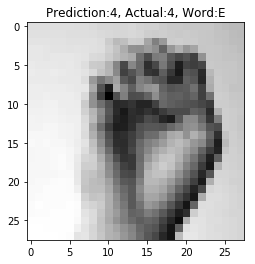

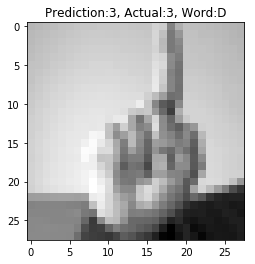

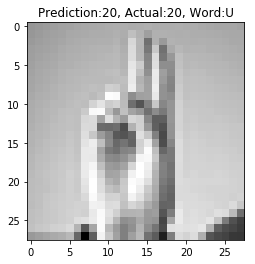

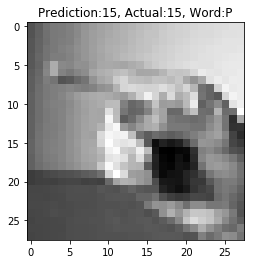

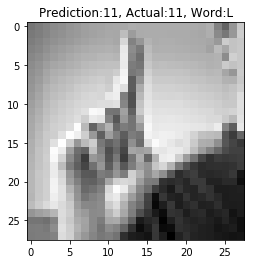

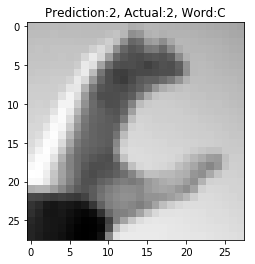

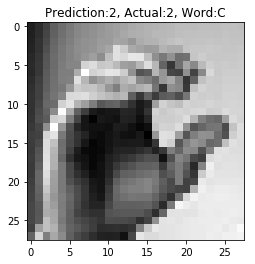

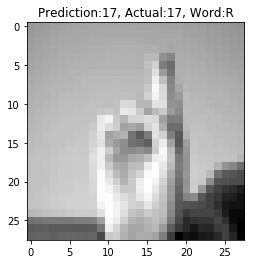

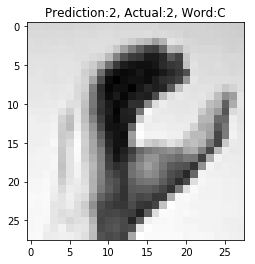

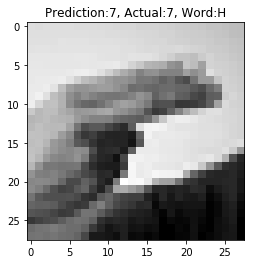

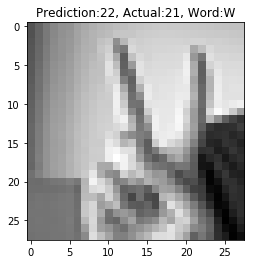

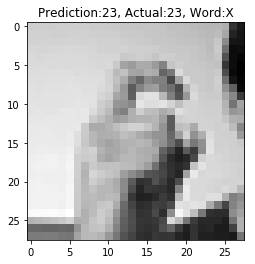

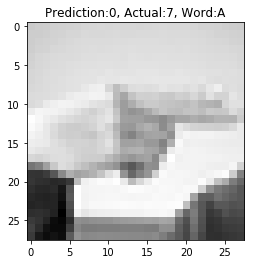

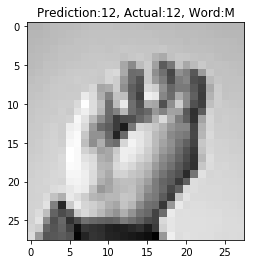

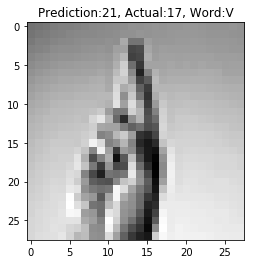

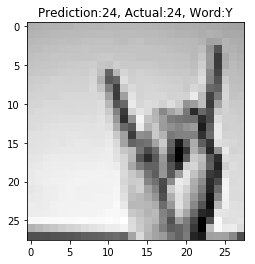

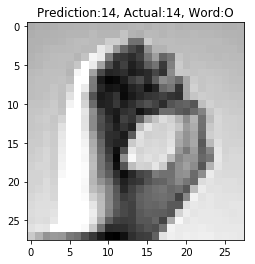

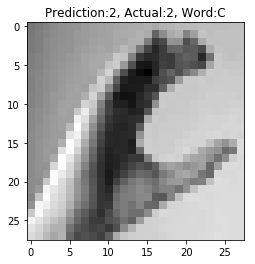

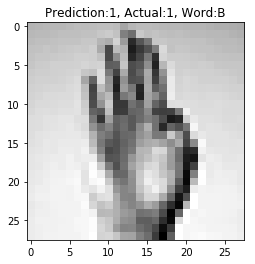

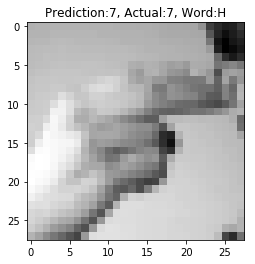

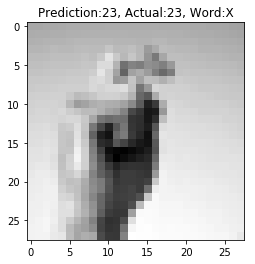

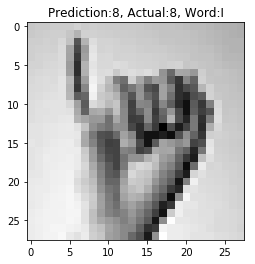

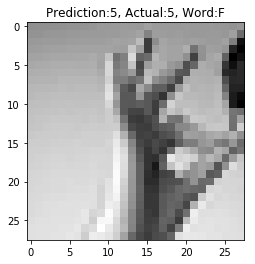

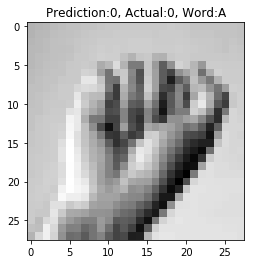

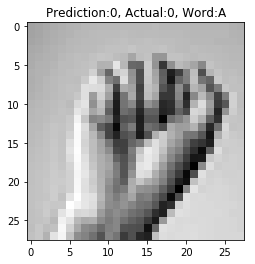

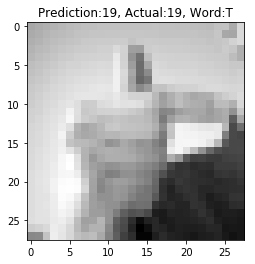

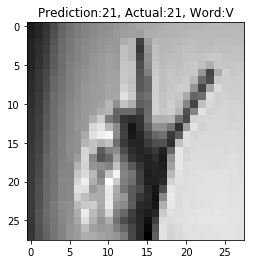

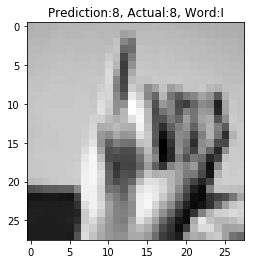

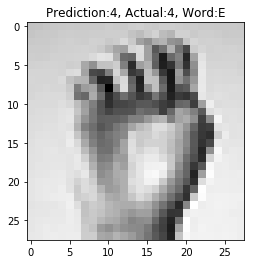

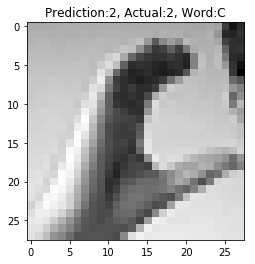

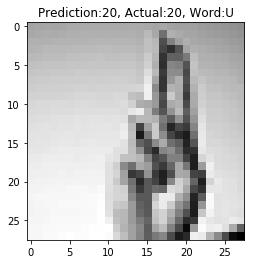

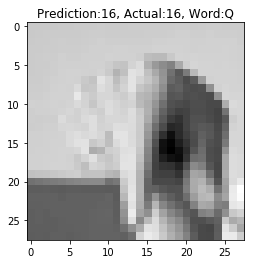

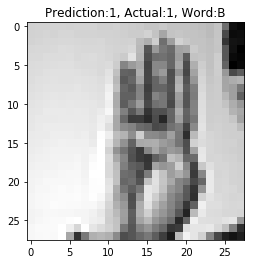

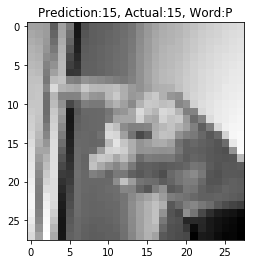

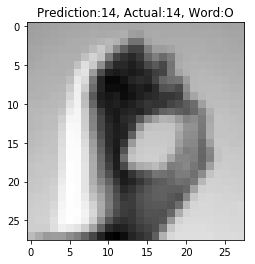

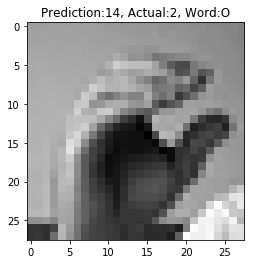

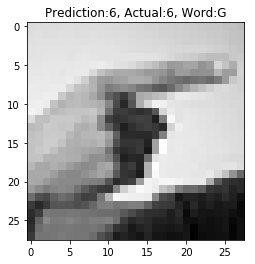

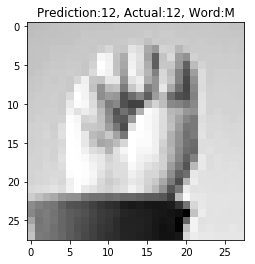

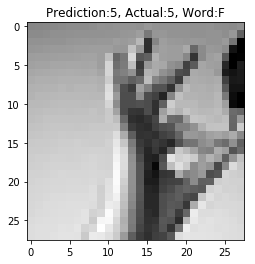

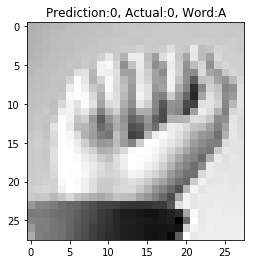

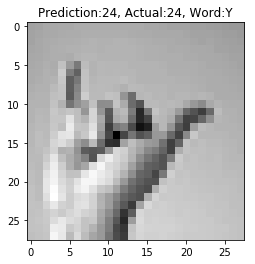

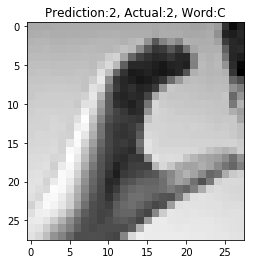

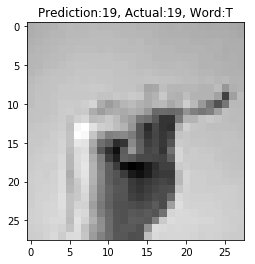

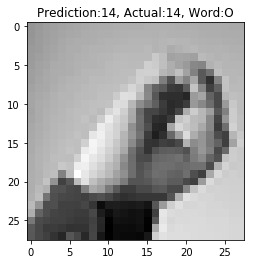

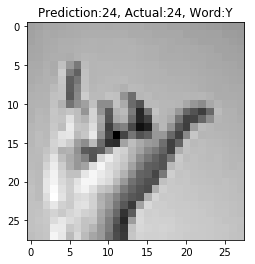

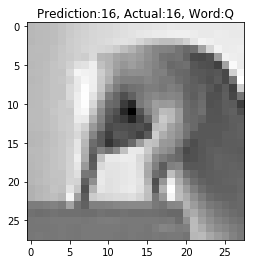

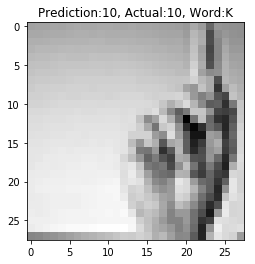

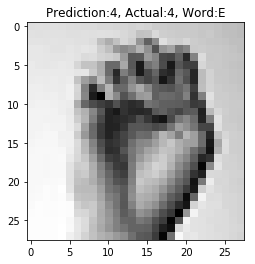

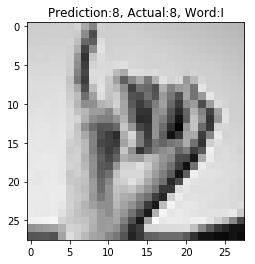

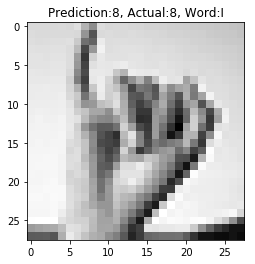

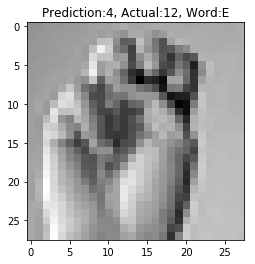

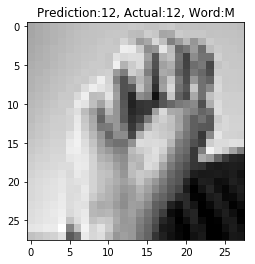

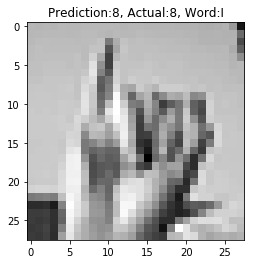

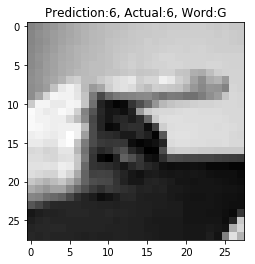

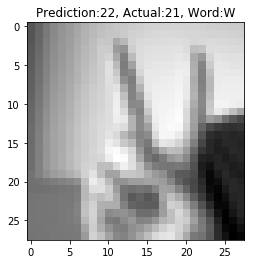

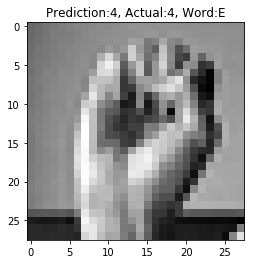

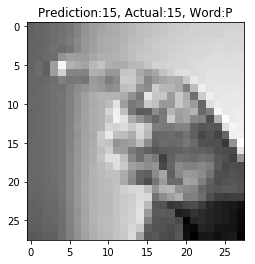

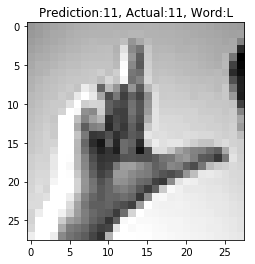

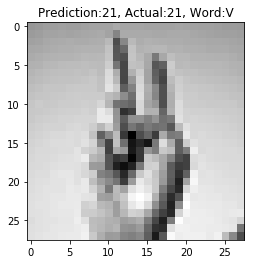

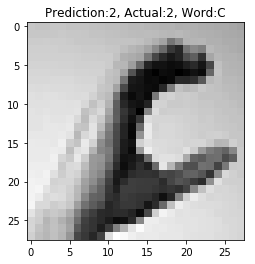

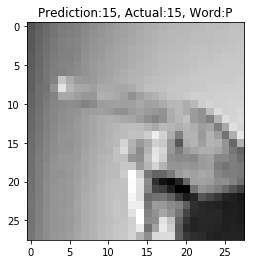

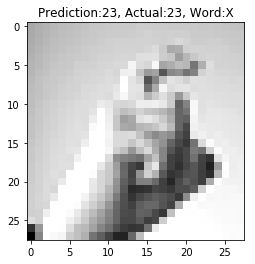

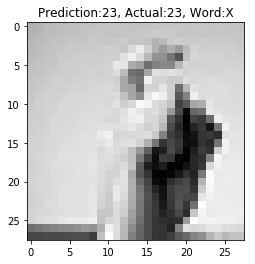

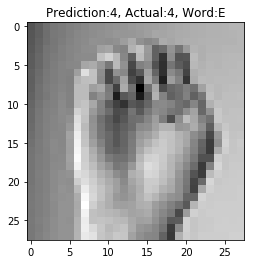

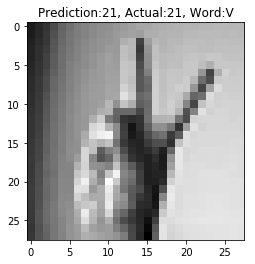

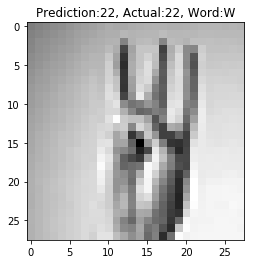

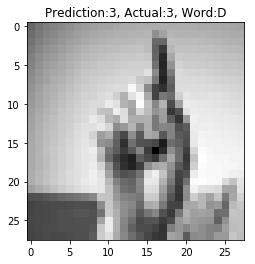

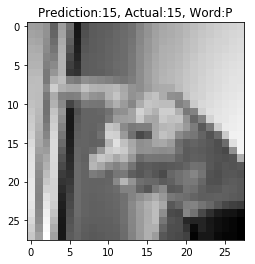

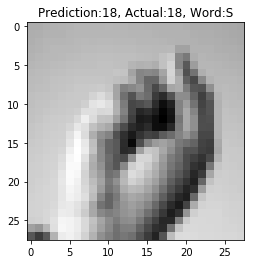

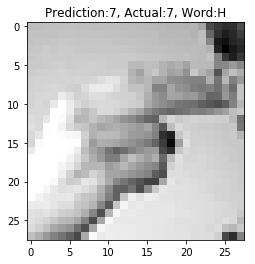

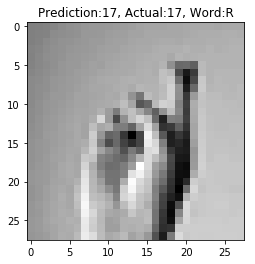

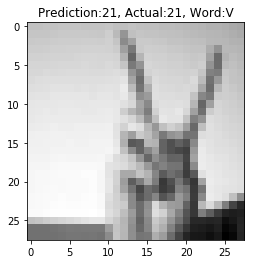

KeyboardInterrupt: 

In [15]:
# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.title("Prediction:%i, Actual:%i, Word:%s" % (preds[i],ltest[i],lbl_map[preds[i]]))
    plt.show()